#### Research question 2 – Classification algorithms comparison
We want to compare some of the main classification algorithms available in scikit-learn library (1. Decision
trees – CART, 2. SVC, 3. K-NN, 4. Naïve Bayes, 5. Logistic Regression) in terms of robustness (measured by
relative loss of performance – LOP, when classifier Performance measured by F1 score) when used in datasets with low (2.5%), medium (10%) and high (25%) levels of attribute noise.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

In [21]:
# Import datasets

cardiotocography = pd.read_csv("https://www.openml.org/data/get_csv/1586231/php9HX2u8")                     #1
iris = pd.read_csv("https://www.openml.org/data/get_csv/61/dataset_61_iris.arff")                           #2
vehicle = pd.read_csv("https://www.openml.org/data/get_csv/54/dataset_54_vehicle.arff")                     #3
parkinsons = pd.read_csv("https://www.openml.org/data/get_csv/1592280/php4ylQmK")                           #4
diabetes = pd.read_csv("https://www.openml.org/data/get_csv/37/dataset_37_diabetes.arff")                   #5
blood_transfusion = pd.read_csv("https://www.openml.org/data/get_csv/1586225/php0iVrYT")                    #6
steel_plates_fault = pd.read_csv("https://www.openml.org/data/get_csv/1592296/php9xWOpn")                   #7
phoneme = pd.read_csv("https://www.openml.org/data/get_csv/1592281/php8Mz7BG")                              #8
# baseball = pd.read_csv("https://www.openml.org/data/get_csv/3622/dataset_189_baseball.arff").dropna().drop(columns = ['Player', 'Position'])       #9
wine = pd.read_csv("https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff")                        #10
letter = pd.read_csv("https://www.openml.org/data/get_csv/6/dataset_6_letter.arff")                         #11
# arrhythmia = pd.read_csv("https://www.openml.org/data/get_csv/5/dataset_5_arrhythmia.arff")                 #12
oil_spill = pd.read_csv("https://www.openml.org/data/get_csv/52215/phpgEDZOc")                              #13
ecoli = pd.read_csv("https://www.openml.org/data/get_csv/39/dataset_39_ecoli.arff")                         #14
glass = pd.read_csv("https://www.openml.org/data/get_csv/41/dataset_41_glass.arff")                         #15
leaf = pd.read_csv("https://www.openml.org/data/get_csv/1590827/phpflaNJC")                                 #16

In [22]:
cardiotocography.rename(columns = {'Class':'class'}, inplace = True)
vehicle.rename(columns = {'Class':'class'}, inplace = True)
parkinsons.rename(columns = {'Class':'class'}, inplace = True)
blood_transfusion.rename(columns = {'Class':'class'}, inplace = True)
steel_plates_fault.rename(columns = {'Class':'class'}, inplace = True)
phoneme.rename(columns = {'Class':'class'}, inplace = True)
# baseball.rename(columns = {'Hall_of_Fame':'class'}, inplace = True)
last_column_wine = wine.pop("class")
wine.insert(13, 'class', last_column_wine)
last_column_oil = oil_spill.pop('class')
oil_spill.insert(49, 'class', last_column_oil)
glass.rename(columns = {'Type':'class'}, inplace = True)
leaf.rename(columns = {'Class':'class'}, inplace = True)

In [23]:
datasets = [cardiotocography, iris, vehicle, parkinsons, diabetes, blood_transfusion, steel_plates_fault, 
              phoneme, wine, letter, oil_spill, ecoli, glass, leaf]
datasets_names = ["cardiotocography", "iris", "vehicle", "parkinsons", "diabetes", "blood_transfusion", "steel_plates_fault", 
                  "phoneme", "wine", "letter", "oil_spill", "ecoli", "glass", "leaf"]

In [24]:
def create_copy(original_dataset_list, new_dataset_list):
    for d in original_dataset_list:
        new_dataser_list = []
        new_dataset_list.append(d.copy(deep=True))

In [25]:
def add_noise(list_of_datasets, noise_perc): 
    np.random.seed(1982)
    # select random rows to add noise
    for d in list_of_datasets:
        d_len = d.shape[0]
        noise_count=int(d_len*noise_perc)
        noise_key = []
        noise_key = np.random.choice(range(0,d_len),noise_count,replace=False)
        number_attributes = d.drop(["class"], axis=1).shape[1]
    # add noise to attributes in randomly selected lines
        for i in range(noise_count):
            for j in range(number_attributes):
                attribute_max = d.iloc[:,j].max()
                attribute_min = d.iloc[:,j].min()
                new_value = np.random.uniform(low=attribute_min, high=attribute_max)
                d.iat[noise_key[i],j] = new_value

In [26]:
datasets_025 = []
datasets_10 = [] 
datasets_25 = []

create_copy(datasets, datasets_025)
add_noise(datasets_025, 0.025)

create_copy(datasets, datasets_10)
add_noise(datasets_10, 0.1)

create_copy(datasets, datasets_25)
add_noise(datasets_25, 0.25)

In [64]:
# def calculate F1_scores for list of datasets

def calculate_F1_scores(list_of_datasets, F1_results_df_name, noise_level):
    clf1 = DecisionTreeClassifier()
    clf2 = svm.SVC()
    clf3 = KNeighborsClassifier()
    clf4 = MultinomialNB()
    clf5 = LogisticRegression(C=1.0, multi_class='multinomial', penalty='l1', solver='saga', tol=0.1)

    clf1_F1_score=[]
    clf2_F1_score=[]
    clf3_F1_score=[]
    clf4_F1_score=[]
    clf5_F1_score=[]

    for d in list_of_datasets: 
        X = d.drop(["class"], axis=1)
        Y = d["class"]
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train_mscale = scaler.fit_transform(X_train)
        X_test_mscale = scaler.fit_transform(X_test)
    
        clf1 = clf1.fit(X_train_mscale, Y_train)
        Y_pred = clf1.predict(X_test_mscale)
        clf1_F1_score.append(f1_score(Y_test, Y_pred, average='macro'))
    
        clf2 = clf2.fit(X_train_mscale, Y_train)
        Y_pred = clf2.predict(X_test_mscale)
        clf2_F1_score.append(f1_score(Y_test, Y_pred, average='macro'))
    
        clf3 = clf3.fit(X_train_mscale, Y_train)
        Y_pred = clf3.predict(X_test_mscale)
        clf3_F1_score.append(f1_score(Y_test, Y_pred, average='macro'))
    
        clf4 = clf4.fit(X_train_mscale, Y_train)
        Y_pred = clf4.predict(X_test_mscale)
        clf4_F1_score.append(f1_score(Y_test, Y_pred, average='macro'))
    
        clf5 = clf5.fit(X_train_mscale, Y_train)
        Y_pred = clf5.predict(X_test_mscale)
        clf5_F1_score.append(f1_score(Y_test, Y_pred, average='macro'))
    
    F1_results_df_name['datasets'] = datasets_names
    F1_results_df_name['decision_tree_F1'] = clf1_F1_score
    F1_results_df_name['SVC_F1'] = clf2_F1_score
    F1_results_df_name['K-NN_F1'] = clf3_F1_score
    F1_results_df_name['Naive-Bayes_F1'] = clf4_F1_score
    F1_results_df_name['Logistic_Regr_F1'] = clf5_F1_score
    
    print(f"Classifiers results (F1 score) for noise {noise_level}:")
    display(F1_results_df_name)

In [65]:
F1_results_0 = pd.DataFrame()
calculate_F1_scores(datasets, F1_results_0, "0.0%")

Classifiers results (F1 score) for noise 0.0%:


,datasets,decision_tree_F1,SVC_F1,K-NN_F1,Naive-Bayes_F1,Logistic_Regr_F1
0,cardiotocography,1.000000,1.000000,1.000000,1.000000,1.000000
1,iris,0.861905,0.975983,0.975983,0.516667,0.952614
2,vehicle,0.705435,0.712393,0.663948,0.470002,0.652730
3,parkinsons,0.879935,0.888258,0.879935,0.819388,0.888258
4,diabetes,0.575479,0.752752,0.690105,0.404639,0.718163
5,blood_transfusion,0.602941,0.512153,0.683230,0.421594,0.514937
6,steel_plates_fault,1.000000,0.998061,0.994213,0.937226,1.000000
7,phoneme,0.652349,0.786533,0.792219,0.415706,0.629438
8,wine,0.946914,0.966989,1.000000,0.950152,0.966989
9,letter,0.815676,0.915978,0.941412,0.509541,0.724072


#### Comments on classification results of the original datasets:
- Specific datasets have very low classification performance or high variation in performance of different classifiers (e.g. ecoli, glass, leaf). Should we replace them with other datasets?
- Naive-Bayes has much lower performance compared to other classifiers in specific datasets (maybe due to attributes independance prerequisit that may not stand - no attribute correlation test was performed in advance?) 

Text(0.5, 1.0, 'Classifiers F1 Scores for Original Datasets - 0 noise')

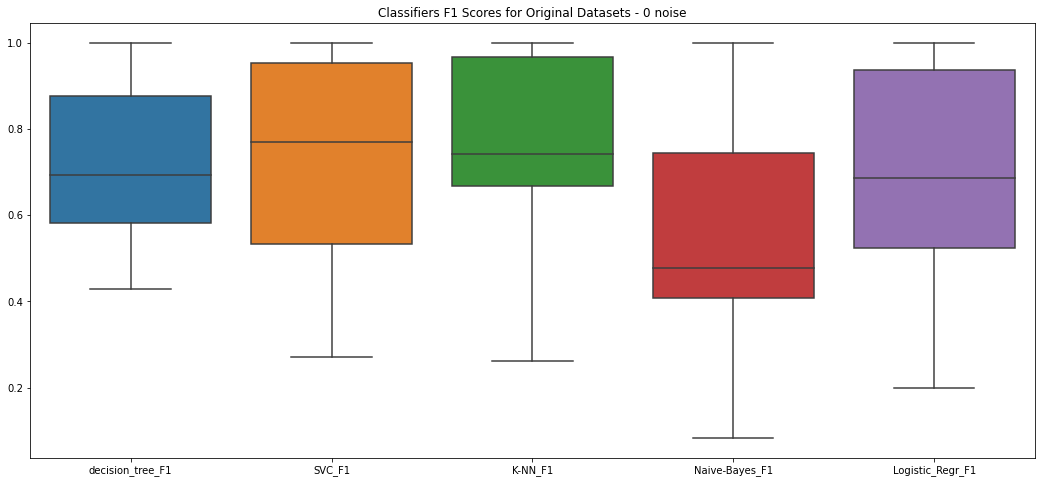

In [66]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data = F1_results_0)
ax.set_title("Classifiers F1 Scores for Original Datasets - 0 noise")

In [30]:
F1_results_025 = pd.DataFrame()
calculate_F1_scores(datasets_025, F1_results_025, "2.5%")

Classifiers results (F1 score) for noise 2.5%:


,datasets,decision_tree_F1,SVC_F1,K-NN_F1,Naive-Bayes_F1,Logistic_Regr_F1
0,cardiotocography,0.980893,0.989641,0.986825,0.987330,0.989220
1,iris,0.952614,0.952614,0.952614,0.516667,0.951178
2,vehicle,0.655777,0.729993,0.626550,0.467267,0.692541
3,parkinsons,0.859524,0.888258,0.906349,0.819388,0.888258
4,diabetes,0.690163,0.727183,0.717019,0.404639,0.683532
5,blood_transfusion,0.580443,0.500214,0.649844,0.421594,0.480289
6,steel_plates_fault,0.990331,0.992213,0.982595,0.962444,0.988351
7,phoneme,0.767399,0.788848,0.824946,0.415706,0.697008
8,wine,0.819267,0.979259,0.979259,0.930317,0.963165
9,letter,0.846177,0.894550,0.919402,0.491159,0.715316


Text(0.5, 1.0, 'Classifiers F1 Scores for Datasets with 2.5% noise')

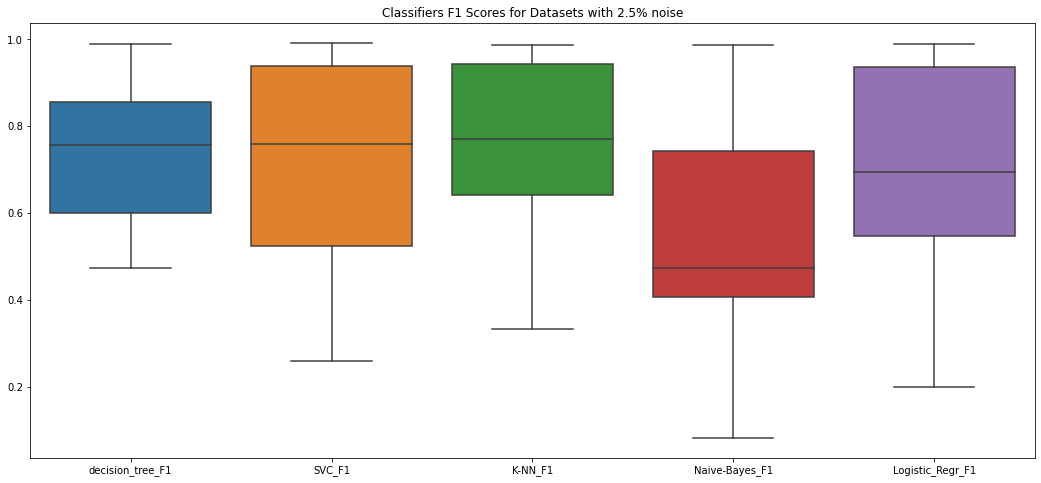

In [31]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=F1_results_025)
ax.set_title("Classifiers F1 Scores for Datasets with 2.5% noise")

In [32]:
F1_results_10 = pd.DataFrame()
calculate_F1_scores(datasets_10, F1_results_10, "10%")

Classifiers results (F1 score) for noise 10%:


,datasets,decision_tree_F1,SVC_F1,K-NN_F1,Naive-Bayes_F1,Logistic_Regr_F1
0,cardiotocography,0.919846,0.951581,0.943411,0.940917,0.941085
1,iris,0.755333,0.883170,0.883170,0.494172,0.813513
2,vehicle,0.640074,0.689950,0.623280,0.427679,0.613558
3,parkinsons,0.859524,0.888258,0.831909,0.819388,0.888258
4,diabetes,0.578396,0.694444,0.693484,0.404639,0.690516
5,blood_transfusion,0.558099,0.455519,0.583134,0.421594,0.473225
6,steel_plates_fault,0.949111,0.949846,0.940786,0.917335,0.944082
7,phoneme,0.765679,0.765841,0.798006,0.415706,0.665816
8,wine,0.725641,0.922005,0.955556,0.875000,0.940186
9,letter,0.773377,0.818852,0.851960,0.436497,0.648119


Text(0.5, 1.0, 'Classifiers F1 Scores for Datasets with 10% noise')

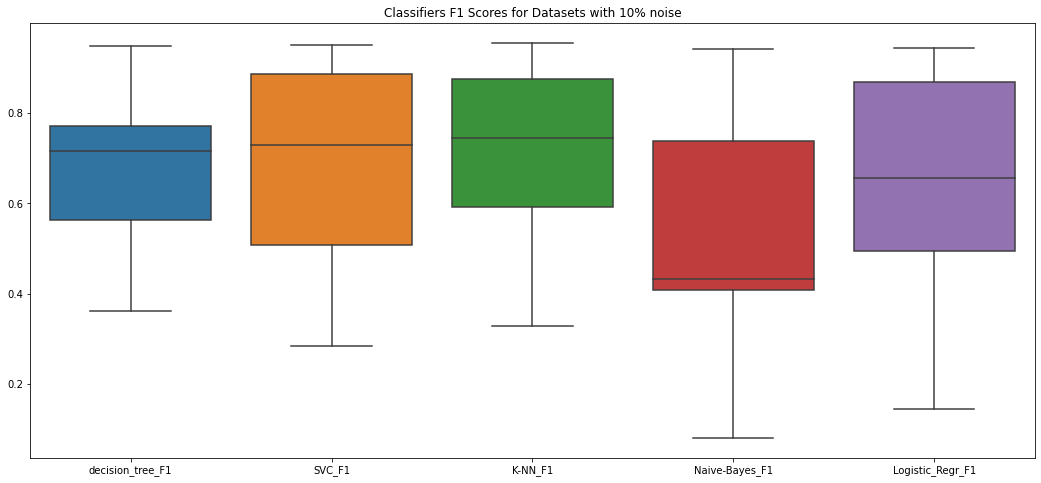

In [33]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=F1_results_10)
ax.set_title("Classifiers F1 Scores for Datasets with 10% noise")

In [34]:
F1_results_25 = pd.DataFrame()
calculate_F1_scores(datasets_25, F1_results_25, "25%")

Classifiers results (F1 score) for noise 25%:


,datasets,decision_tree_F1,SVC_F1,K-NN_F1,Naive-Bayes_F1,Logistic_Regr_F1
0,cardiotocography,0.798715,0.878970,0.837965,0.868844,0.869597
1,iris,0.665601,0.756410,0.761182,0.396028,0.653423
2,vehicle,0.569701,0.605907,0.523680,0.415404,0.554591
3,parkinsons,0.785610,0.888258,0.879935,0.819388,0.888258
4,diabetes,0.632227,0.614192,0.632099,0.404639,0.590264
5,blood_transfusion,0.564726,0.421594,0.590806,0.421594,0.438809
6,steel_plates_fault,0.864415,0.906745,0.882036,0.787520,0.901035
7,phoneme,0.731729,0.712664,0.740622,0.415706,0.542405
8,wine,0.713117,0.871554,0.881295,0.833838,0.833270
9,letter,0.642062,0.681890,0.719444,0.307271,0.472700


Text(0.5, 1.0, 'Classifiers F1 Scores for Datasets with 25% noise')

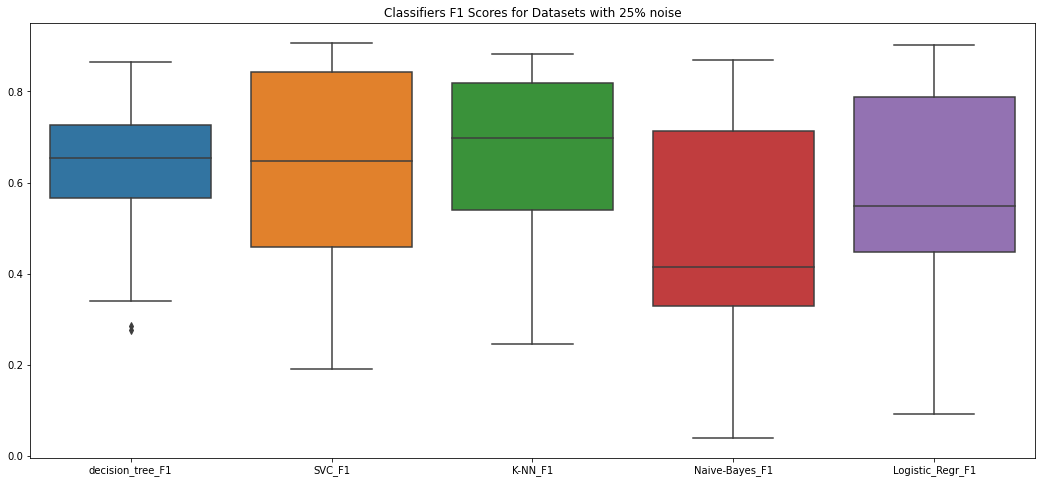

In [35]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=F1_results_25)
ax.set_title("Classifiers F1 Scores for Datasets with 25% noise")

In [37]:
def calculate_L0P(d0, dn, LOP_df_name, noise_level):
    decision_tree_LOP = (d0["decision_tree_F1"] - dn["decision_tree_F1"])/d0["decision_tree_F1"]
    SVC_LOP = (d0["SVC_F1"] - dn["SVC_F1"])/d0["SVC_F1"]
    KNN_LOP = (d0["K-NN_F1"] - dn["K-NN_F1"])/d0["K-NN_F1"]
    Naive_Bayes_LOP = (d0["Naive-Bayes_F1"] - dn["Naive-Bayes_F1"])/d0["Naive-Bayes_F1"]
    Logistic_Regr_LOP = (d0["Logistic_Regr_F1"] - dn["Logistic_Regr_F1"])/d0["Logistic_Regr_F1"]

    LOP_df_name['datasets'] = datasets_names
    LOP_df_name['decision_tree_LOP'] = decision_tree_LOP
    LOP_df_name['SVC_LOP'] = SVC_LOP
    LOP_df_name['K-NN_LOP'] = KNN_LOP
    LOP_df_name['Naive-Bayes_LOP'] = Naive_Bayes_LOP
    LOP_df_name['Logistic_Regr_LOP'] = Logistic_Regr_LOP
    
    print(f"Loss of Performance (F1 score % drop) for noise {noise_level}:")
    display(LOP_df_name)

In [38]:
Loss_of_Perf_025 = pd.DataFrame()
calculate_L0P(F1_results_0, F1_results_025, Loss_of_Perf_025, "2.5%")

Loss of Performance (F1 score % drop) for noise 2.5%:


,datasets,decision_tree_LOP,SVC_LOP,K-NN_LOP,Naive-Bayes_LOP,Logistic_Regr_LOP
0,cardiotocography,0.013734,0.010359,0.013175,0.012670,0.010780
1,iris,-0.105243,0.023944,0.023944,0.000000,0.001507
2,vehicle,0.021070,-0.024706,0.056326,0.005818,0.000179
3,parkinsons,-0.023262,0.000000,-0.030019,0.000000,-0.026901
4,diabetes,-0.140140,0.033967,-0.039000,0.000000,0.040946
5,blood_transfusion,0.009094,0.023311,0.048864,0.000000,0.082355
6,steel_plates_fault,0.009669,0.005859,0.011686,-0.026907,0.011649
7,phoneme,-0.192579,-0.002944,-0.041311,0.000000,-0.082408
8,wine,0.134803,-0.012689,0.020741,0.020875,0.003954
9,letter,-0.038145,0.023395,0.023380,0.036075,0.038775


Text(0.5, 1.0, 'Loss of Performance (F1 Scores decrease) with the addition of 2.5% noise')

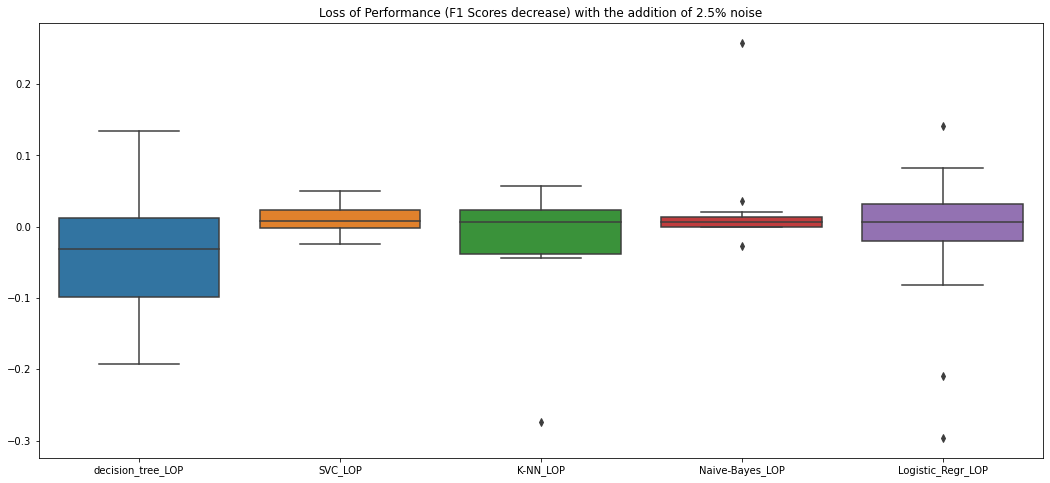

In [39]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=Loss_of_Perf_025)
ax.set_title("Loss of Performance (F1 Scores decrease) with the addition of 2.5% noise")

In [40]:
Loss_of_Perf_10 = pd.DataFrame()
calculate_L0P(F1_results_0, F1_results_10, Loss_of_Perf_10, "10%")

Loss of Performance (F1 score % drop) for noise 10%:


,datasets,decision_tree_LOP,SVC_LOP,K-NN_LOP,Naive-Bayes_LOP,Logistic_Regr_LOP
0,cardiotocography,0.075115,0.048419,0.056589,0.059083,0.058915
1,iris,0.123647,0.095097,0.095097,0.043537,0.146021
2,vehicle,0.044510,0.031503,0.061251,0.090049,0.114206
3,parkinsons,-0.023262,0.000000,0.054579,0.000000,-0.026901
4,diabetes,0.044499,0.077459,-0.004897,0.000000,0.031147
5,blood_transfusion,0.047238,0.110582,0.146504,0.000000,0.095853
6,steel_plates_fault,0.050889,0.048309,0.053739,0.021223,0.055918
7,phoneme,-0.189906,0.026308,-0.007304,0.000000,-0.033969
8,wine,0.233678,0.046519,0.044444,0.079095,0.027718
9,letter,0.051170,0.106035,0.095019,0.143354,0.129073


Text(0.5, 1.0, 'Loss of Performance (F1 Scores decrease) with the addition of 10% noise')

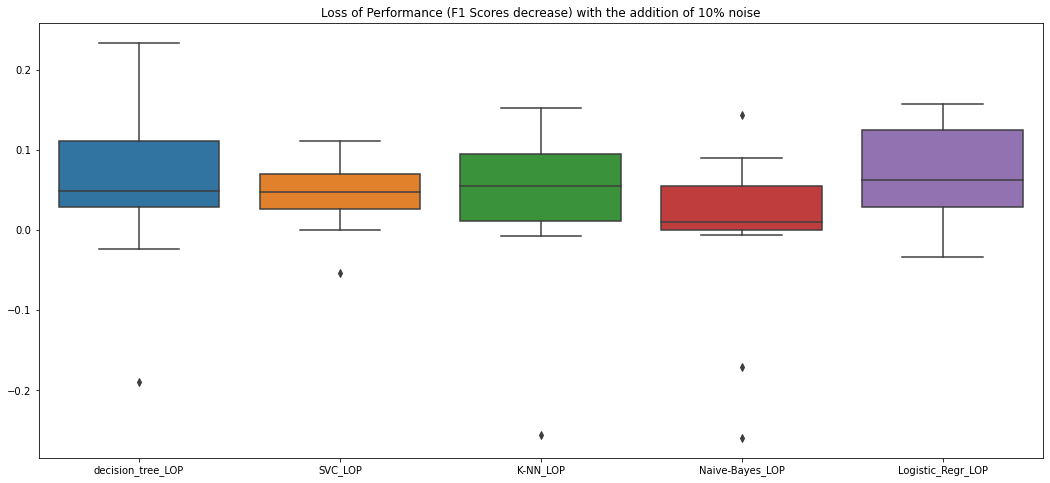

In [41]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=Loss_of_Perf_10)
ax.set_title("Loss of Performance (F1 Scores decrease) with the addition of 10% noise")

In [42]:
Loss_of_Perf_25 = pd.DataFrame()
calculate_L0P(F1_results_0, F1_results_25, Loss_of_Perf_25, "25%")

Loss of Performance (F1 score % drop) for noise 25%:


,datasets,decision_tree_LOP,SVC_LOP,K-NN_LOP,Naive-Bayes_LOP,Logistic_Regr_LOP
0,cardiotocography,0.196909,0.121030,0.162035,0.131156,0.130403
1,iris,0.227756,0.224976,0.220087,0.233493,0.314074
2,vehicle,0.149562,0.149477,0.211264,0.116165,0.199337
3,parkinsons,0.064732,0.000000,0.000000,0.000000,-0.026901
4,diabetes,-0.044430,0.184071,0.084054,0.000000,0.171809
5,blood_transfusion,0.035926,0.176821,0.135275,0.000000,0.161607
6,steel_plates_fault,0.135585,0.091494,0.112830,0.159732,0.098965
7,phoneme,-0.137146,0.093916,0.065129,0.000000,0.157681
8,wine,0.246904,0.098692,0.118705,0.122416,0.138283
9,letter,0.212276,0.255561,0.235782,0.396965,0.364796


Text(0.5, 1.0, 'Loss of Performance (F1 Scores decrease) with the addition of 25% noise')

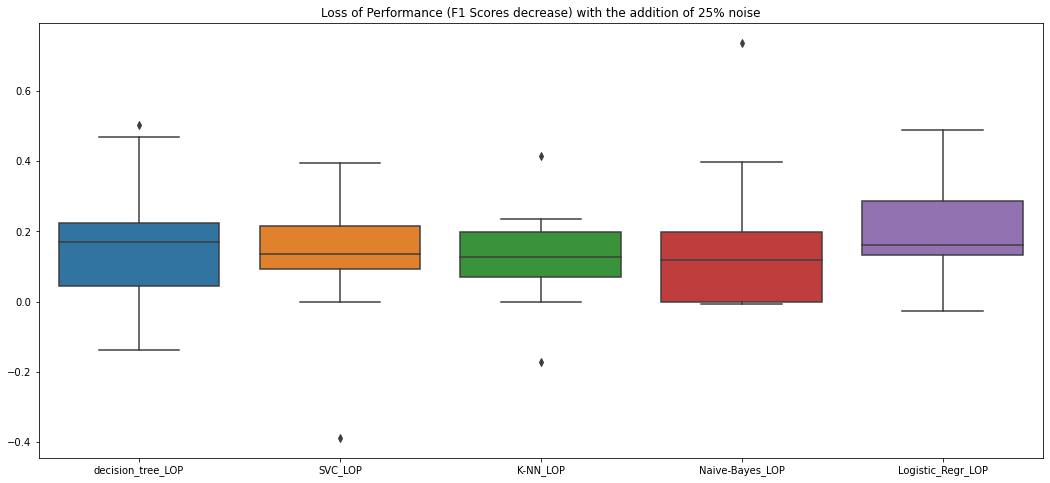

In [43]:
f = plt.figure(figsize=(18,8))
ax = sns.boxplot(data=Loss_of_Perf_25)
ax.set_title("Loss of Performance (F1 Scores decrease) with the addition of 25% noise")

#### Apply statistical tests to evaluate results

In [44]:
# First we need to test whether our data are normaly distributed (in order to decide if we will apply parametric or
# non parametric statistical tests)

# Shapiro-Wilk test for normality

from scipy import stats

def calc_shapiro_pvalue(df, list_name):
    for i in range(len(df.columns)):
        shapiro_test = stats.shapiro(df.iloc[1:,i])
        list_name.append(shapiro_test.pvalue)

# Null Hypothesis: sample is drown from a normal distribution
# a level selected: 0.05,
# if the p value is less than the chosen alpha level (p<0.05), then the null hypothesis is rejected 
# and there is evidence that the data tested are not normally distributed

# if p>>0.05 the null hypothesis cannot be rejected (and we can assume that data are normaly distributed)

In [46]:
shapiro_pvalues_LOP_025=[]
calc_shapiro_pvalue(Loss_of_Perf_025.drop(["datasets"], axis=1), shapiro_pvalues_LOP_025)

shapiro_pvalues_LOP_10=[]
calc_shapiro_pvalue(Loss_of_Perf_10.drop(["datasets"], axis=1), shapiro_pvalues_LOP_10)

shapiro_pvalues_LOP_25=[]
calc_shapiro_pvalue(Loss_of_Perf_25.drop(["datasets"], axis=1), shapiro_pvalues_LOP_25)

shapiro_pvalues = pd.DataFrame({"classifiers": ["decision_tree", "SVC", "K-NN", "Naive-Bayes", "Logistic Regression"],
                                "2.5% noise LOP pvalues": shapiro_pvalues_LOP_025,
                                "10% noise LOP pvalues": shapiro_pvalues_LOP_10,
                                "25% noise LOP pvalues": shapiro_pvalues_LOP_25})

In [46]:
display(shapiro_pvalues)

,classifiers,2.5% noise LOP pvalues,10% noise LOP pvalues,25% noise LOP pvalues
0,decision_tree,0.036126,0.007191,0.232589
1,SVC,0.900830,0.570929,0.025711
2,K-NN,0.000297,0.003443,0.719909
3,Naive-Bayes,0.000004,0.010543,0.001609
4,Logistic Regression,0.202866,0.009129,0.009907
5,Random Forest,0.067878,0.001710,0.000023


#### Null Hypothesis (sample is drown from normal distribution) can be rejected for several of the sample sets (p-value<0.05) and we cannot use statistical tests that require normality.

#### So in order to compare the different classifiers for noise robustness we will use the Kruskal-Wallis H-test

In [47]:
# One-Way ANOVA test (for normally distributed populations, having the same standard deviation): 
# WE CANNOT USE IT IN THIS CASE! - UNLESS BY ADDING MORE DATASETS WE END UP WITH NORMAL DISTRIBUTIONS

from scipy.stats import f_oneway

f_oneway(Loss_of_Perf_025["decision_tree_LOP"], Loss_of_Perf_025["SVC_LOP"],Loss_of_Perf_025["K-NN_LOP"], 
          Loss_of_Perf_025["Naive-Bayes_LOP"], Loss_of_Perf_025["Logistic_Regr_LOP"])

# Method outputs:
# statistics --> the computed F statistic of the test (F-test) & p-value

# The null hypothesis (H0): The means of a given set of normally distributed populations, all having the same standard 
# deviation, are equal

# Alternative hypothesis (Ha): At least one of the groups mean is different from the others.

F_onewayResult(statistic=1.3894129618847582, pvalue=0.24742493751022474)

In [48]:
f_oneway(Loss_of_Perf_10["decision_tree_LOP"], Loss_of_Perf_10["SVC_LOP"],Loss_of_Perf_10["K-NN_LOP"], 
          Loss_of_Perf_10["Naive-Bayes_LOP"], Loss_of_Perf_10["Logistic_Regr_LOP"])

F_onewayResult(statistic=1.171265362850776, pvalue=0.3317102182830415)

In [49]:
f_oneway(Loss_of_Perf_25["decision_tree_LOP"], Loss_of_Perf_25["SVC_LOP"],Loss_of_Perf_25["K-NN_LOP"], 
          Loss_of_Perf_25["Naive-Bayes_LOP"], Loss_of_Perf_25["Logistic_Regr_LOP"])

F_onewayResult(statistic=0.593764823712772, pvalue=0.6683805985040416)

In [50]:
# Kruskal-Wallis H-test (non parametric - normality is not a prerequisite)

from scipy import stats

stats.kruskal(Loss_of_Perf_025["decision_tree_LOP"], Loss_of_Perf_025["SVC_LOP"],Loss_of_Perf_025["K-NN_LOP"], 
          Loss_of_Perf_025["Naive-Bayes_LOP"], Loss_of_Perf_025["Logistic_Regr_LOP"])


# The null hypothesis (H0): The median across the groups are equal

# The alternative hypothesis: (Ha): At least one of the median is different from the others.

KruskalResult(statistic=3.5634771834088346, pvalue=0.46829236490544857)

In [51]:
stats.kruskal(Loss_of_Perf_10["decision_tree_LOP"], Loss_of_Perf_10["SVC_LOP"],Loss_of_Perf_10["K-NN_LOP"], 
          Loss_of_Perf_10["Naive-Bayes_LOP"], Loss_of_Perf_10["Logistic_Regr_LOP"])

KruskalResult(statistic=4.6066925036153314, pvalue=0.3300832837368788)

In [52]:
stats.kruskal(Loss_of_Perf_25["decision_tree_LOP"], Loss_of_Perf_25["SVC_LOP"],Loss_of_Perf_25["K-NN_LOP"], 
          Loss_of_Perf_25["Naive-Bayes_LOP"], Loss_of_Perf_25["Logistic_Regr_LOP"])

KruskalResult(statistic=2.664335401767691, pvalue=0.6154697250855112)

#### Null Hypothesis cannot be rejected for any of the 3 noise levels (as pvalue > 0.05 in all cases)

#### Conclusion: there is no evidence that any of the classifiers are significanlty more or less robust to attribute noise than the rest.

In [ ]:
# Next steps: We can add more data (more datasets) and/or use different-additional classifiers